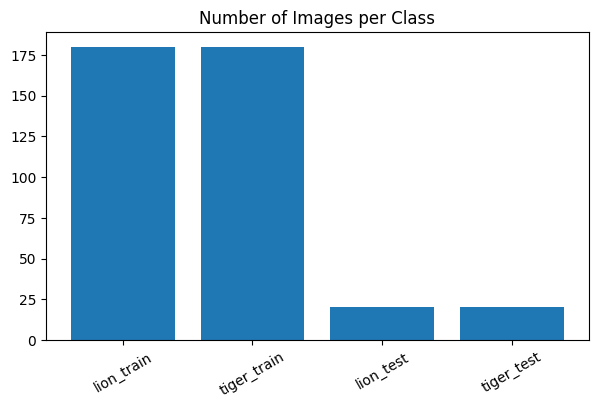

Found 360 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


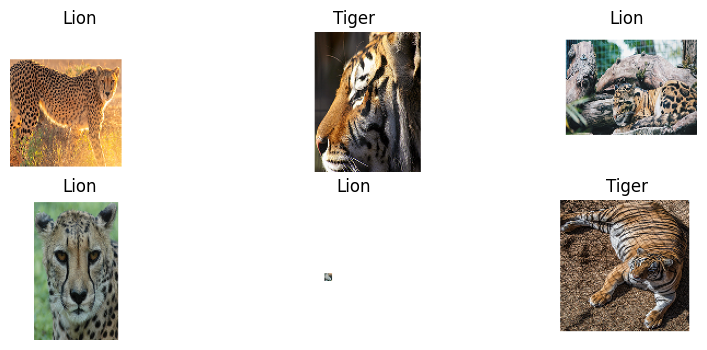

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.5295 - loss: 0.9310 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5517 - loss: 0.6908 - val_accuracy: 0.4250 - val_loss: 0.6924
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5435 - loss: 0.6873 - val_accuracy: 0.5500 - val_loss: 0.6922
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5887 - loss: 0.6699 - val_accuracy: 0.5500 - val_loss: 0.6885
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6328 - loss: 0.6363 - val_accuracy: 0.6500 - val_loss: 0.6652
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6840 - loss: 0.6050 - val_accuracy: 0.5250 - val_loss: 0.6592
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7652 - loss: 0.5414 - val_accuracy: 0.4250 - val_loss: 0.7706
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7583 - loss: 0.5262 - val_accuracy: 0.62

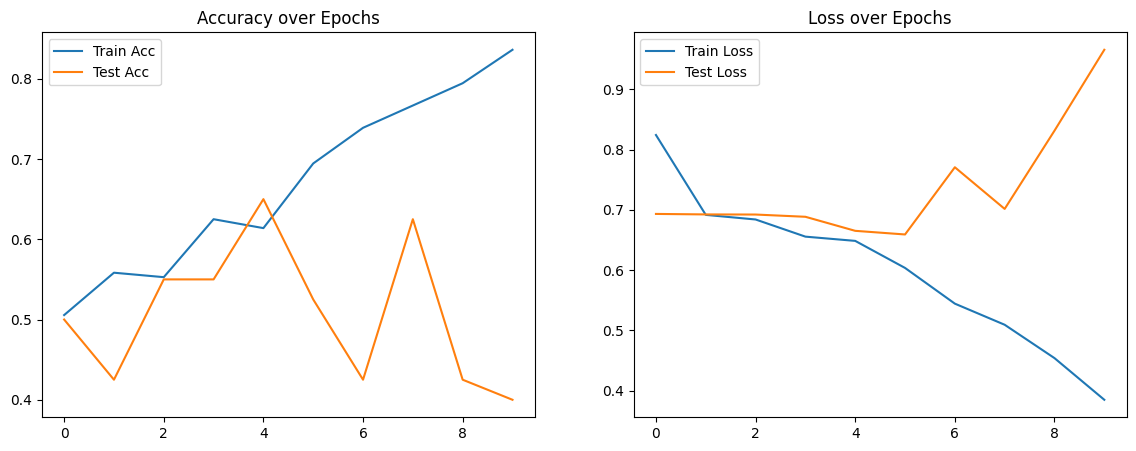

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


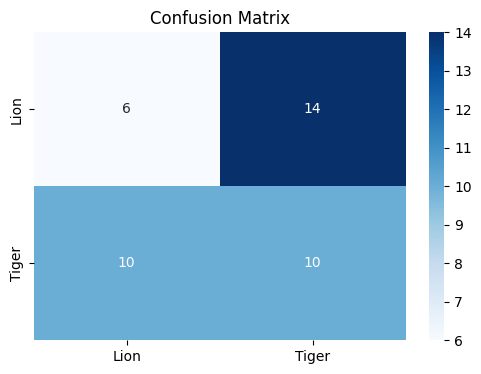


✅ Final Test Accuracy: 40.00%


Classification Report:

              precision    recall  f1-score   support

        Lion       0.38      0.30      0.33        20
       Tiger       0.42      0.50      0.45        20

    accuracy                           0.40        40
   macro avg       0.40      0.40      0.39        40
weighted avg       0.40      0.40      0.39        40



In [6]:
# ============================
# SUPPRESS ALL WARNINGS / LOGS
# ============================
import os
import warnings
warnings.filterwarnings("ignore")

# Suppress TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # 0 = all logs, 3 = only fatal errors

# After setting env vars, import TF
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

# Optional: Disable absl logs
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# ===============================
# IMPORTS
# ===============================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# ======================================
# DATA PATHS
# ======================================
train_dir = "/kaggle/input/lions-and-tigers/train"
test_dir  = "/kaggle/input/lions-and-tigers/test"

# ======================================
# 1. IMAGE COUNT VISUALIZATION
# ======================================
class_counts = {
    "lion_train": len(os.listdir(os.path.join(train_dir, "lion"))),
    "tiger_train": len(os.listdir(os.path.join(train_dir, "tiger"))),
    "lion_test": len(os.listdir(os.path.join(test_dir, "lion"))),
    "tiger_test": len(os.listdir(os.path.join(test_dir, "tiger")))
}

plt.figure(figsize=(7,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of Images per Class")
plt.xticks(rotation=30)
plt.show()

# ======================================
# DATA GENERATORS
# ======================================
img_size = (128,128)

train_gen = ImageDataGenerator(rescale=1/255.0)
test_gen  = ImageDataGenerator(rescale=1/255.0)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=32, class_mode="binary"
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=32, class_mode="binary", shuffle=False
)

# ======================================
# 2. DISPLAY SAMPLE IMAGES
# ======================================
def show_samples(generator):
    x, y = next(generator)
    plt.figure(figsize=(10,4))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(x[i])
        plt.title("Lion" if y[i]==0 else "Tiger")
        plt.axis("off")
    plt.show()

show_samples(train_data)

# ======================================
# 3. SIMPLE CNN
# ======================================
model = Sequential([
    tf.keras.Input(shape=(128,128,3)),

    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ======================================
# 4. TRAIN 10 EPOCHS
# ======================================
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    verbose=1
)

# ======================================
# 5. ACCURACY & LOSS GRAPHS
# ======================================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Test Acc")
plt.title("Accuracy over Epochs")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()

# ======================================
# 6. CONFUSION MATRIX
# ======================================
pred = model.predict(test_data)
pred_labels = (pred > 0.5).astype(int).flatten()

cm = confusion_matrix(test_data.classes, pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Lion","Tiger"],
            yticklabels=["Lion","Tiger"])
plt.title("Confusion Matrix")
plt.show()

# ======================================
# 7. FINAL TEST ACCURACY
# ======================================
loss, acc = model.evaluate(test_data, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc*100:.2f}%\n")

print("\nClassification Report:\n")
print(classification_report(test_data.classes, pred_labels, target_names=["Lion","Tiger"]))
